<a href="https://colab.research.google.com/github/dataqueenpend/HandsOnML_projects/blob/main/Hands_on_ML_Regression_House_Prices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code in this notebook belongs to the creators of Hands on ML book. [Source]('https://github.com/ageron/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb')
It is a part of exercise in the book.

#For the environment globally

In [1]:
import os
import tarfile
import urllib.request
import sklearn
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

#For the plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

#For images
PROJECT_ROOT_DIR = '.'
CHAPTER_ID = 'end_to_end_project'
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, 'images', CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension='png', resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + '.' + fig_extension)
  print('Saving figure', fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format=fig_extension, dpi=resolution)

#Part of code responsible for downloading the data in tgz file (compressed csv). 

##Function that fetches latest data automatically

In [2]:
DOWNLOAD_ROOT = 'https://raw.githubusercontent.com/ageron/handson-ml2/master/'
HOUSING_PATH = os.path.join('datasets', 'housing')
HOUSING_URL = DOWNLOAD_ROOT + 'datasets/housing/housing.tgz'

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
  os.makedirs(housing_path, exist_ok=True)
  tgz_path = os.path.join(housing_path, 'housing.tgz')
  urllib.request.urlretrieve(housing_url, tgz_path)
  housing_tgz = tarfile.open(tgz_path)
  housing_tgz.extractall(path=housing_path)
  housing_tgz.close()

In [4]:
fetch_housing_data()

##Loading data with pandas 

In [5]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
  csv_path = os.path.join(housing_path, 'housing.csv')
  return pd.read_csv(csv_path)

#First look on the data

In [6]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
housing.shape

(20640, 10)

In [8]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


* Seems like total_bedrooms have some missing values - 20433 non-null/20640 possible.

* ocean_proximity is an object type data, which in this case means categorical feature
  > let's take a look on the unique categories 

In [9]:
housing['ocean_proximity'].unique()

array(['NEAR BAY', '<1H OCEAN', 'INLAND', 'NEAR OCEAN', 'ISLAND'],
      dtype=object)

In [10]:
housing['ocean_proximity'].value_counts(ascending=False)

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

Taking a look at some summary statics of the numerical features. 

In [11]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


Checking out numerical values with hist() function

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f47649a6390>,
      dtype=object)

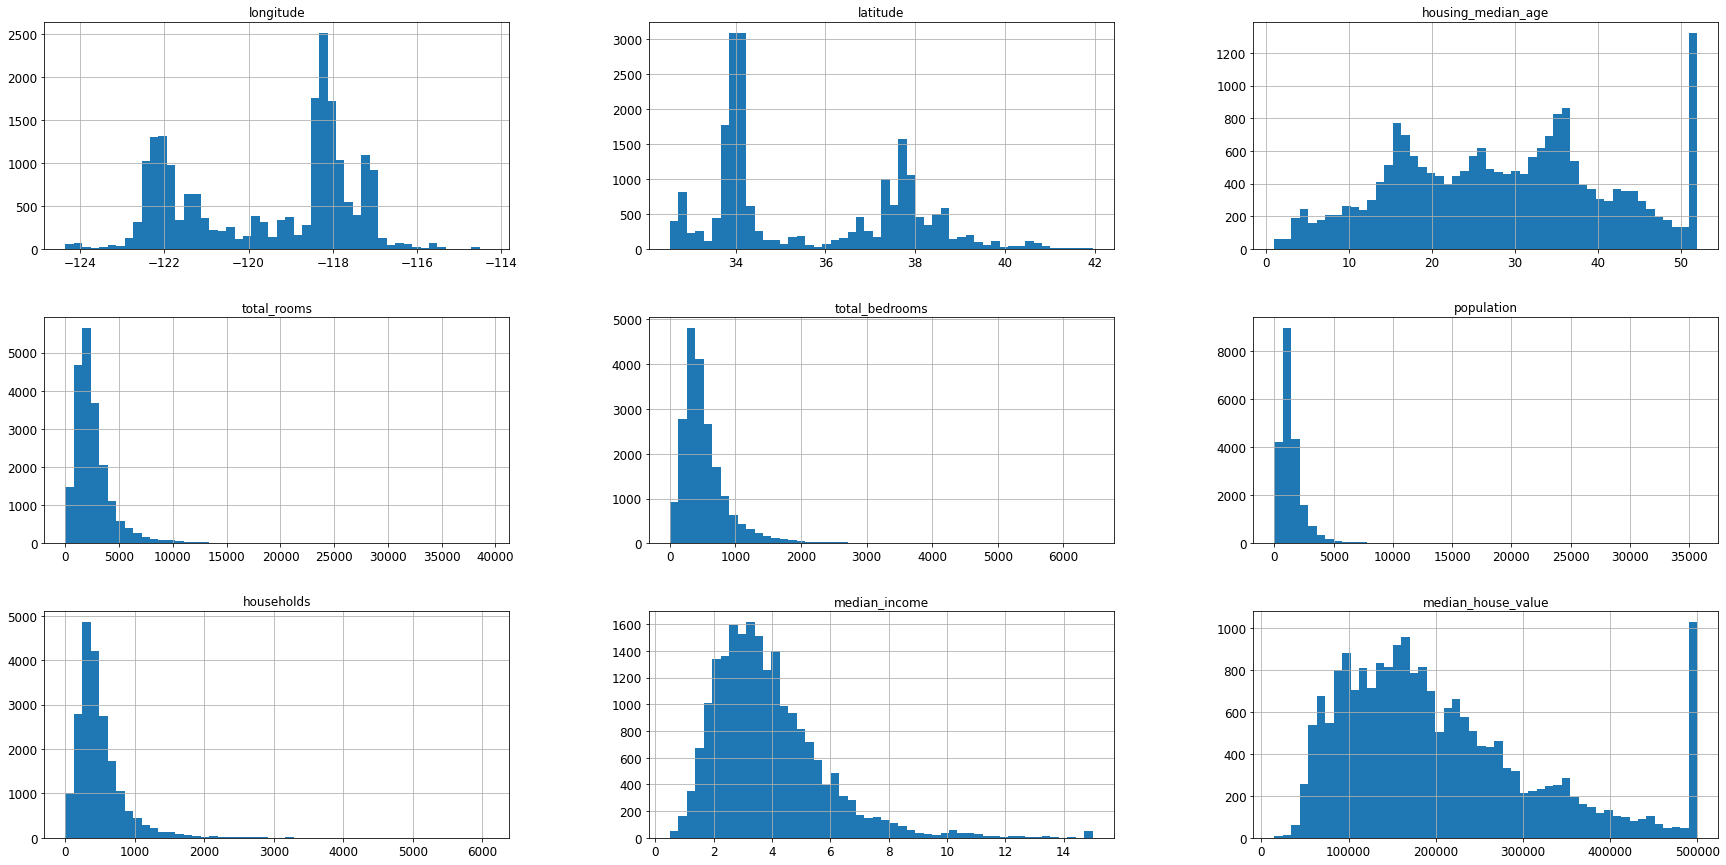

In [12]:
housing.hist(bins=50, figsize=(30,15))


* median_income values are not measured in USD, but it is scaled and capped at 15 001 and 0.4999.  The numbers are representing roughly 10 000 usd. So 2 is 20 000. 
* another capped valaues are housing_median_age and median_house_value - the median_house_value which is our target is ending at 500000 which can be a problem. ML can learn, that there are no houses above this value. This can be deal with with one of the two way: 
  * colects proper labels for the district which were capped
  * removes those districts from the dataset - it will prevent the poor evaluation of prediction, which should be predicted beyond 50 0000. 

* features ared scaled different - it is a case for later (feature scaling)
* some of the features have right tails, which can be troublesome to work with with some ml algorithms - this also needs to be addressed later. 

##Splitting the data

It is a good practice to set random_seed, that function will select always the same set of data for training and test, everytime it is called. Not doing so can cause in time, that model will see in time all the data from both training and test set. 

But if the next update will come up, it could brake the data. The solution for this is setting up instance's identifier, that would decide if the will go in the test or training set. 

In [13]:
#Split function
def split_function(data, test_ratio):
  shuffled_indices = np.random.permutation(len(data))
  test_set_size = int(len(data) * test_ratio)
  test_indices = shuffled_indices[:test_set_size]
  train_indices = shuffled_indices[test_set_size:]
  return data.iloc[train_indices], data.iloc[test_indices]

In [14]:
train_set, test_set = split_function(housing, 0.2)

In [15]:
len(train_set)

16512

In [16]:
len(test_set)

4128

In [17]:
from zlib import crc32
def test_set_check(identifier, test_ratio):
  return crc32(np.int64(identifier) & 0xffffffff < test_ratio * 2**32)

In [18]:
def split_train_test_by_id(data, test_ratio, id_column):
  ids = data[id_column]
  in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
  return data.loc[~in_test_set], data.loc[in_test_set]

In [19]:
housing_with_id = housing.reset_index()

In [20]:
housing_with_id.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [21]:
#train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, 'index')

The same thing as the function split_train_test is doing the dunction from sckit-learn library - train_test_split. And it's also have a couple of additional features. Like for example random_state. 
> Also by using train_test_split function from sklearn we can split multiple datasets on the same indices. (number of rows must be identical?) This feature can be use if we have seperate dataframe for labels. 



##Splitting with sklearn

In [22]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

###Creating income category

In [23]:
housing['income_cat'] = pd.cut(housing['median_income'], bins=[0.,1.5,3.0,4.5,6.0, np.inf], labels=[1,2,3,4,5])

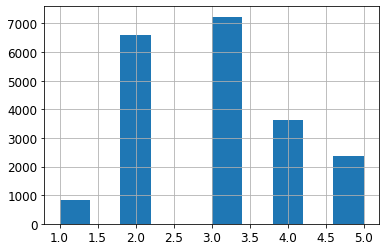

In [24]:
housing['income_cat'].hist()

###StratifiedShuffleSplit

In order to receive representive set of data we will use stratified sampling based on the income category. 
> It is important to have representitive set of data due to statistics reason -> check out more about stratified data in the Hand on ML (54,55 | Chapter 2: End-to-End Machine Learning Project) book or just on the internet. 

To create more representitive dataset we'll use sklearn StratiffiedShuffleSplit class.

In [25]:
from sklearn.model_selection import StratifiedShuffleSplit

In [26]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

In [27]:
for train_index, test_index in split.split(housing, housing['income_cat']):
  strat_train_set = housing.loc[train_index]
  strat_test_set = housing.loc[test_index]

In [28]:
strat_test_set['income_cat'].value_counts()/len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114341
1    0.039971
Name: income_cat, dtype: float64

We can measure the income category proportion in random set, full set and stratified set. 

In [29]:
def income_proportions(data):
  return data['income_cat'].value_counts()/len(data)

In [30]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [31]:
comparison = pd.DataFrame({
    'Full dataset': income_proportions(housing),
    'Stratified': income_proportions(strat_test_set),
    'Random': income_proportions(test_set)
}).sort_index()

In [32]:
comparison['Random % error'] = 100 * comparison['Random']/ comparison['Full dataset'] - 100
comparison['Stratified % error'] = 100 * comparison['Stratified']/ comparison['Full dataset'] - 100

In [33]:
comparison

,Full dataset,Stratified,Random,Random % error,Stratified % error
1,0.039826,0.039971,0.040213,0.973236,0.364964
2,0.318847,0.318798,0.324370,1.732260,-0.015195
3,0.350581,0.350533,0.358527,2.266446,-0.013820
4,0.176308,0.176357,0.167393,-5.056334,0.027480
5,0.114438,0.114341,0.109496,-4.318374,-0.084674


Removing income category. 

In [34]:
for set_ in (strat_train_set, strat_test_set):
  set_.drop('income_cat', axis=1, inplace=True)

##EDA

Setting out the test set aside, we'll perform our exploration on train data only. If we'd be dealing with a large dataset, we could sample an exploration set. 

> We'll be doing EDA on the copy of the training set, to not mess up the original. 

In [35]:
housing = strat_train_set.copy()

###Geogrphical data visualization

We can visualize the geographical data (longitude, latitude)

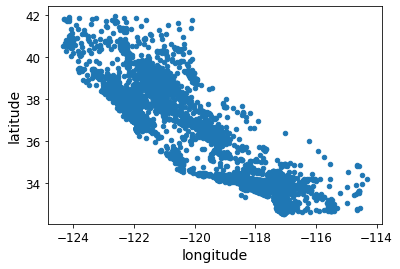

In [36]:
housing.plot(x='longitude', y = 'latitude', kind='scatter')

Check out that!
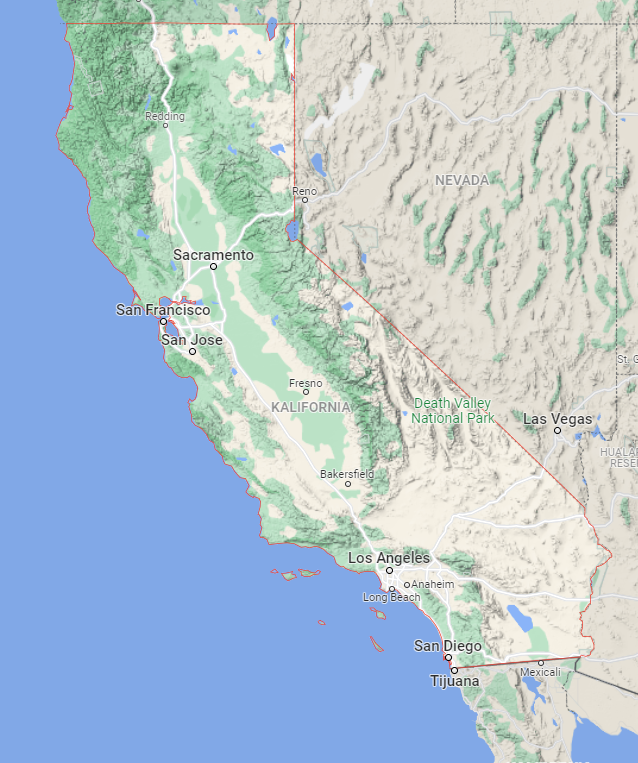
It is California

To see better where, the density of those data points is, we'll set up alpha parameter.

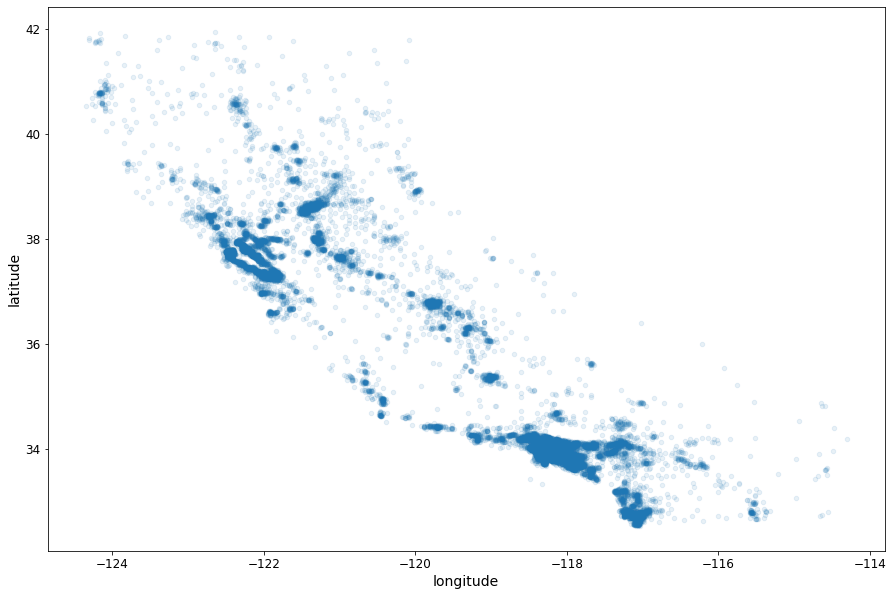

In [37]:
housing.plot(kind='scatter', x='longitude', y='latitude', alpha=0.1, figsize=(15, 10))

From the vis we can see easily now, where are the high-density areas. Los Angeles, San Francisco, San Diego are the places with the largest number of the data points. 



###Adding house prices and population

* circles are districts populations
* color represents prices (blue - lowest, red - highest)

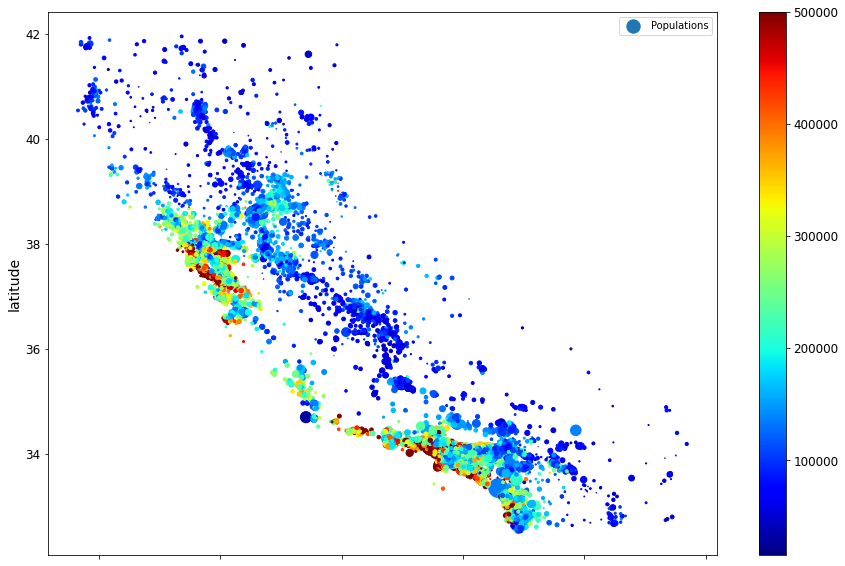

In [38]:
housing.plot(kind='scatter', x='longitude', y='latitude', 
             s=housing['population']/100, label='Populations',
             c=housing['median_house_value'], cmap=plt.get_cmap('jet'), 
             colorbar=True, figsize=(15,10))
plt.legend()

From the plot we can spot, that around the costline, and those which are the most populated, are the ones, that have the highest house prices. 




####Data Vis with California image

In the handson-ml2 notebook (link in the beggining), there is also a part of code, which allow us to plot our data on the geo-photo of California. 

Let's check it out!

In [39]:
#Downloading California image from the handson-ml2 repository
images_path = os.path.join(PROJECT_ROOT_DIR, 'images', 'end_to_end_project')
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = 'california.png'
print('Downloading', filename)
url = DOWNLOAD_ROOT + 'images/end_to_end_project/' + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('./images/end_to_end_project/california.png',
 <http.client.HTTPMessage at 0x7f476171ab10>)

Saving figure california_housing_prices_plot


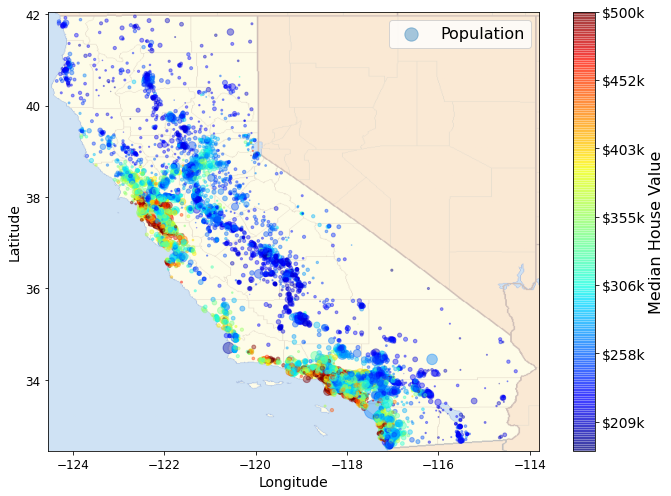

In [40]:
import matplotlib.image as mpimg
california_img = mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind='scatter', x='longitude', y='latitude', figsize=(10,7),
                  s=housing['population']/100, label='Population',
                  c='median_house_value', cmap=plt.get_cmap('jet'),
                  colorbar=False, alpha=0.4)
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap('jet'))
plt.ylabel('Latitude', fontsize=14)
plt.xlabel('Longitude', fontsize=14)

prices = housing['median_house_value']
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(['$%dk'%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig('california_housing_prices_plot')
plt.show()

###Correlations

We'll compute Pearon's Correlations coefficient for every feature pair in the dataset. 

In [41]:
corr_matrix = housing.corr()

In [42]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.687151
total_rooms           0.135140
housing_median_age    0.114146
households            0.064590
total_bedrooms        0.047781
population           -0.026882
longitude            -0.047466
latitude             -0.142673
Name: median_house_value, dtype: float64

Calculating the correlation coefficient tells us:
* there is a **positive correlation** between median_house_value and median_income
* the is a slight **negative correlation** between latitude and media_house_value 
> meaning when the houses are located more to the North, the values of the house decreases

---

Side note! -> correlation coefficient measures only linear correlations (as above). It is not sensitive to nonlinear relationships.
> 'if is close to 0 ,then y generally goes up'*

*Discover and Visualize the Data to Gain Insights | 59


###Pandas scatter matrix

Plots correlations between every num col in the dataaset against eveey num col in the dataset.

In order to not spam all the 121 plots, we'll just check couple of the attributes.

In [43]:
from pandas.plotting import scatter_matrix

In [44]:
attributes = ["median_house_value", "median_income", "total_rooms",
"housing_median_age"]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f476154ac50>,
      dtype=object)

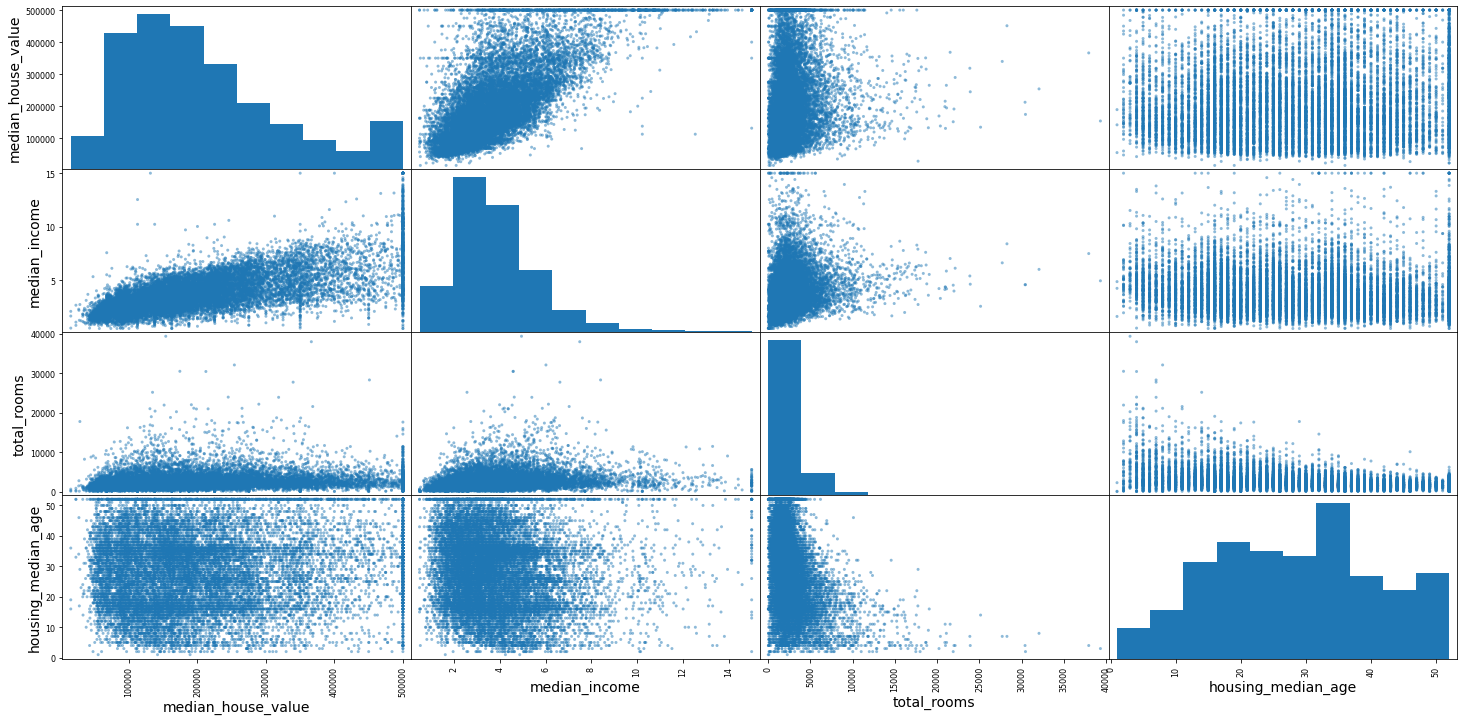

In [45]:
scatter_matrix(housing[attributes], figsize=(25, 12))

From the scatter matrix, wew can see that the most promising attribute for predicting median house value is the median income. 

Let's take a closer look at this plot. 

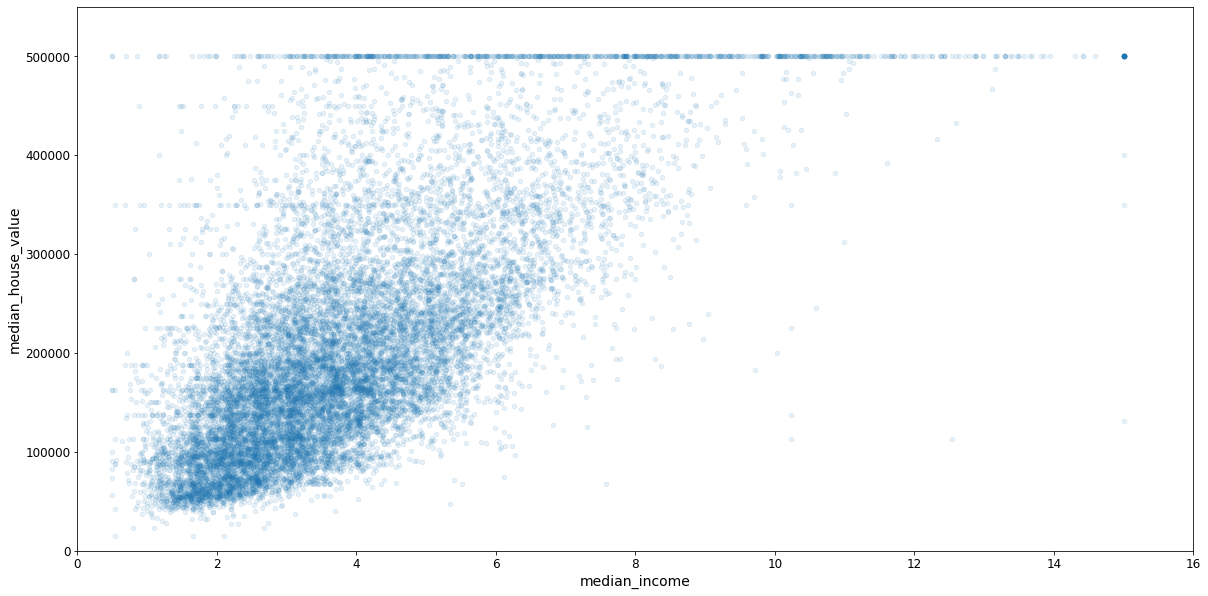

In [46]:
housing.plot(kind='scatter', x='median_income', y='median_house_value', alpha=0.1)
plt.axis([0,16, 0, 550000])
plt.gcf().set_size_inches(20,10)

With this plot, we can see clearly couple of things:
* there is a horizontal line at the price cap level $500 000

and further there are also couple of other possible lines:
* around $450 000

* around $350 000

* around $280 000

and couple of more below this level. 

It is possible that, these lines will need to be removed - to prevent algorithms from learnings these.

###Experimenting with Attribute Combinations

In [47]:
housing['rooms_per_household'] = housing['total_rooms']/housing['households']
housing['bedrooms_per_rooms'] = housing['total_bedrooms']/housing['total_rooms']
housing['population_per_household'] = housing['population']/housing['households']

In [48]:
corr_matrix = housing.corr()

In [49]:
corr_matrix['median_house_value'].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687151
rooms_per_household         0.146255
total_rooms                 0.135140
housing_median_age          0.114146
households                  0.064590
total_bedrooms              0.047781
population_per_household   -0.021991
population                 -0.026882
longitude                  -0.047466
latitude                   -0.142673
bedrooms_per_rooms         -0.259952
Name: median_house_value, dtype: float64

As we can spot, our newly created variable - bedrooms_per_household is more correlated with target variable than the original variable number of rooms or bedrroms. It seems that houses with lower bedroom/room ratio tend to be more expensive. 

The other variable - rooms_per_household is also more valuable than the total_rooms variable (total_rooms in a district). It shows positive correlation with target variable, meanning - bigger house are more expensive. 

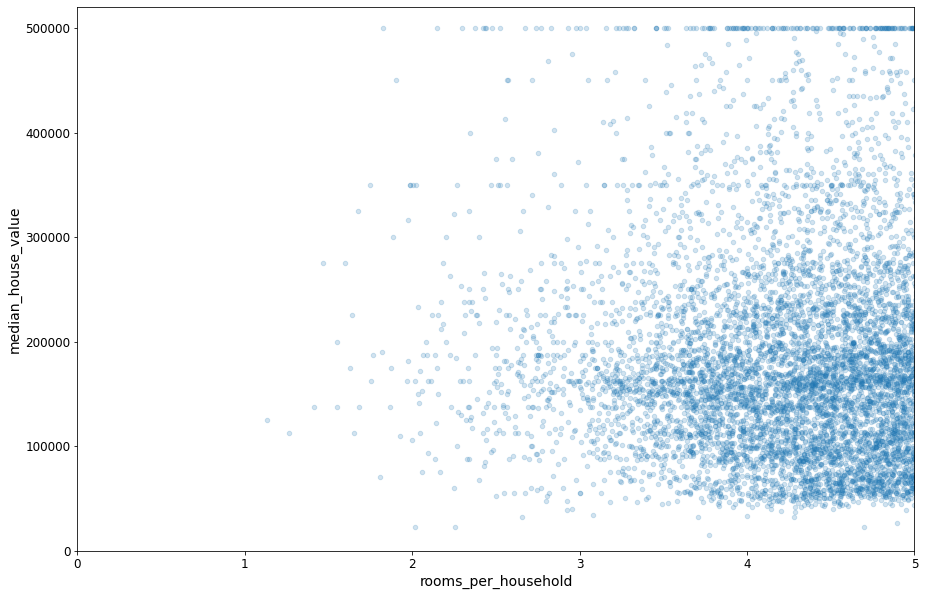

In [50]:
housing.plot(kind='scatter', x='rooms_per_household', y='median_house_value', alpha=0.2)
plt.axis([0,5,0,520000])
plt.gcf().set_size_inches(15,10)
plt.show()

##Feature Engineering

In [51]:
#Reverting to clean training set
housing = strat_train_set.drop('median_house_value', axis=1)
housing_labels = strat_train_set['median_house_value'].copy()

###Data Cleaning

#####Missing values

We have couple of options here:
* get rid of the corresponding to nans districts


```
housing.dropna(subset=["total_bedrooms"])
```


* removing whole columns


```
housing.drop("total_bedrooms", axis=1) 
```


* setting values to mean/median


```
median = housing["total_bedrooms"].median() 
housing["total_bedrooms"].fillna(median, inplace=True)
```


---

> Median/mean value computed in the training set needs to be saved for later use -> imputing nans in test set. 

####Scikit-learn use 

Instead of doing the imputation by hand. We'll use the SimpleImputer from scikit-learn to do it. 

In [52]:
from sklearn.impute import SimpleImputer

In [53]:
#Creating a simple imputer object with median as a strategy
imputer = SimpleImputer(strategy='median')

In [54]:
imputer.strategy

'median'

In [55]:
#Dropping object column
housing_num = housing.drop('ocean_proximity', axis=1)

In [56]:
#Fitting imputer to the data
imputer.fit(housing_num)

SimpleImputer(strategy='median')

The median values for each variable is stored in statistics_ instance variable. 

In [57]:
imputer.statistics_

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

In [58]:
housing_num.median().values

array([-118.51   ,   34.26   ,   29.     , 2119.     ,  433.     ,
       1164.     ,  408.     ,    3.54155])

Now, we can use the remembered median values to impute nan's in the training set. 

In [59]:
X = imputer.transform(housing_num)

In order to use the data in the form of the dataframe, we need to put it back to pandas DF. Simple imputer changed the format of our data to a numpy array.

In [60]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, 
                          index=housing_num.index)

In [61]:
housing_tr.isnull().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
dtype: int64

###Text and categorical attributes

There is only one  categorical feature in this daataset -> ocean_proximity. Let's check its first 10 instances. 

In [62]:
housing_cat = housing[['ocean_proximity']]

In [63]:
housing_cat.head(10)

,ocean_proximity
12655,INLAND
15502,NEAR OCEAN
2908,INLAND
14053,NEAR OCEAN
20496,<1H OCEAN
1481,NEAR BAY
18125,<1H OCEAN
5830,<1H OCEAN
17989,<1H OCEAN
4861,<1H OCEAN


It's typical categorical attribute. Where eaach possible value represents a category. ML algorithms (mmost of them) prefer to work with numbers. So we need to convert these categories to numbers. 

---
To accomplish that we'll use OrdinalEncoder class.

In [64]:
from sklearn.preprocessing import OrdinalEncoder

In [65]:
ordinal_encoder = OrdinalEncoder()

In [66]:
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)

In [67]:
housing_cat_encoded[:10]

array([[1.],
       [4.],
       [1.],
       [4.],
       [0.],
       [3.],
       [0.],
       [0.],
       [0.],
       [0.]])

In [68]:
#Checking list of categories
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

#####One-Hot Encoder

By using Ordinal Encoder we can allow algorithm to learn, that there is some relation between categories which number representation are close to each other (for example 0, 1). 

To fix that we can create one binary attribute per category. Meaning if cat is <1H OCEAN parameter will value will equal to 1, and if not it, value will be 0. 

> This is called One-Hot Encodding. 

New attributes can be called sometimes dummy attributes. 

In [69]:
from sklearn.preprocessing import OneHotEncoder

In [70]:
cat_encoder = OrdinalEncoder()

In [71]:
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

In [72]:
housing_cat_1hot

array([[1.],
       [4.],
       [1.],
       ...,
       [0.],
       [0.],
       [1.]])

In [73]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

####Custom transformers

In [74]:
from sklearn.base import BaseEstimator, TransformerMixin

In [78]:
#Hardcoded indices
rooms_ix, bedrooms_ix, population_ix, households_ix = 3,4,5,6

Hardcoded indices are not the best approach. They can be got dynamically with this code:

In [80]:
col_names = "total_rooms", "total_bedrooms", "population", "households"
rooms_ix, bedrooms_ix, population_ix, households_ix = [housing.columns.get_loc(c) for c  in col_names]

In [79]:
class CombinedAttributeAdder(BaseEstimator, TransformerMixin):
  def __init__(self, add_bedrooms_per_room = True):
    self.add_bedrooms_per_room = add_bedrooms_per_room
  def fit(self, X):
    return self
  def transform(self, X):
    rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
    population_per_household = X[:, population_ix] / X[:, households_ix]

    if self.add_bedrooms_per_room:
      bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
      return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
    else:
      return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributeAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)



housing_extra_attribs transformed df to np array, and we've lost column names. Concerting to df again, then. 

In [81]:
housing_extra_attribs = pd.DataFrame(
    housing_extra_attribs,
    columns=list(housing.columns)+["rooms_per_household", "population_per_household"],
    index=housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_household,population_per_household
12655,-121.46,38.52,29,3873,797,2237,706,2.1736,INLAND,5.48584,3.16856
15502,-117.23,33.09,7,5320,855,2015,768,6.3373,NEAR OCEAN,6.92708,2.6237
2908,-119.04,35.37,44,1618,310,667,300,2.875,INLAND,5.39333,2.22333
14053,-117.13,32.75,24,1877,519,898,483,2.2264,NEAR OCEAN,3.88613,1.85921
20496,-118.7,34.28,27,3536,646,1837,580,4.4964,<1H OCEAN,6.09655,3.16724


##Feature scaling

ML algos don't perform well on features with different scales, so FS is a must! 
In this dataset we have f.e. total number of rooms ranges from 6 to 39 320, and another feature median income have range from 0 to 15. 

> **Scaling a target values is not required**!

---
We can approach FS with one of two ccommon ways:
* min-max scaling
  * min-max scaling - (sometimes called normatlization) is shiftfing and resacling values, that they end up in ranges from 0 to 1. It is done by subtracting the min value and dividing by the max minus min. 
  > To do so we can use trasnformer from scikit-learn called MinMaxScaler. It also has a hyperparameter feature_range, which allos to change the scales to different than 0-1.
* standarization - 
  * subtracts the mean value (standarized values have always zero mean), and divides by the std, result has unit variance. Standarization is not bounding the values to specific range (like min-max), and this could be a problem for some algos. Standarization is less affected by the outliers. 
  > To use standarization we can go with StandardScaler from scikit-learn

Remember that, we fit the transformers only to the training set. And use this fitted (to the training data) values to transform the test set (and new data). 






###Transformation Pipelines



####Num trasnformer Pipeline

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [83]:
num_pipeline = Pipeline([
                         ('imputer', SimpleImputer(strategy='median')),
                         ('attribs_ader', CombinedAttributeAdder()),
                         ('std_scaler', StandardScaler()),
])

In [84]:
housing_num_tr = num_pipeline.fit_transform(housing_num) 

In [85]:
housing_num_tr

array([[-0.94135046,  1.34743822,  0.02756357, ...,  0.01739526,
         0.00622264, -0.12112176],
       [ 1.17178212, -1.19243966, -1.72201763, ...,  0.56925554,
        -0.04081077, -0.81086696],
       [ 0.26758118, -0.1259716 ,  1.22045984, ..., -0.01802432,
        -0.07537122, -0.33827252],
       ...,
       [-1.5707942 ,  1.31001828,  1.53856552, ..., -0.5092404 ,
        -0.03743619,  0.32286937],
       [-1.56080303,  1.2492109 , -1.1653327 , ...,  0.32814891,
        -0.05915604, -0.45702273],
       [-1.28105026,  2.02567448, -0.13148926, ...,  0.01407228,
         0.00657083, -0.12169672]])

####All round transfomer Pipeline
by using Columns transfomer deisgned to hande both categorical and numerical columns. 

In [86]:
from sklearn.compose import ColumnTransformer

In [87]:
num_attribs = list(housing_num)

In [88]:
cat_attribs = ['ocean_proximity']

In [89]:
full_pipeline = ColumnTransformer([
                                   ('num', num_pipeline, num_attribs), 
                                   ('cat', OneHotEncoder(), cat_attribs),
])

In [90]:
housing_prepared = full_pipeline.fit_transform(housing)

In [91]:
housing_prepared.shape

(16512, 16)

In hands on ml notebook we can also check, how the pipeline were done earrlier. 

##Select and Traind a Model

We've:
1. Done Eda
2. Sampled training, test set
3. Wrote transfromations pipelines
---
Next step is selecting the model!

###Training and evaluating on the Training Set

####LinearRegression model

In [92]:
from sklearn.linear_model import LinearRegression

In [94]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

Trying the LinReg out on a few inatnces from the training set:

In [96]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
print('Predictions:', lin_reg.predict(some_data_prepared))

Predictions: [ 85657.90192014 305492.60737488 152056.46122456 186095.70946094
 244550.67966089]


In [98]:
print('Labels:', list(some_labels))

Labels: [72100.0, 279600.0, 82700.0, 112500.0, 238300.0]


As we can see the predictions are not accurate. Let's take a measure of the accuracy with RMSE.
> We'll do it with Scikit-Learn mean_squred_error() function

In [99]:
from sklearn.metrics import mean_squared_error

In [100]:
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68627.87390018745

Typical prediction error is 68,628 $ , which is not very satisfying, taking into consideration that `median_house_values` range between 120,000 $ and 265,000 $.


---

It is an example of underfitting. Which means that features are not very infromative to predict the target, or model is not powerful enough.

What can we do now?
* provide better features
* reduce constraints to the model (this is not the case here, model is not regularized)

Also we can add more features - log of the population for example. But first we'll try more complex model and see what will happen. 

####DecisionTreeRegressor

> model which is capable of finding nonlinear relationshi in the data. 

In [101]:
from sklearn.tree import DecisionTreeRegressor

In [102]:
tree_reg = DecisionTreeRegressor()

In [103]:
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor()

In [104]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

And here we have - ladies and gents - probably example of overfitting. Why?

####Evaluation using cross-validation